In [31]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#### Data Preparation

In [32]:
# read data
X_train = np.load('C:/Users/KingO/JupyterProject/stock-market-prediction/data/pca_features/X_train.npy')
y_train_ = np.load('C:/Users/KingO/JupyterProject/stock-market-prediction/data/pca_features/y_train.npy',allow_pickle=True)
X_test = np.load('C:/Users/KingO/JupyterProject/stock-market-prediction/data/pca_features/X_test.npy')
y_test_ = np.load('C:/Users/KingO/JupyterProject/stock-market-prediction/data/pca_features/y_test.npy',allow_pickle=True)
sc_params = np.load('C:/Users/KingO/JupyterProject/stock-market-prediction/data/pca_features/sc_params.npy')

In [33]:
# flatten features to fit in SVM
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(f"number of train data: {X_train.shape[0]}\t number of test data: {X_test.shape[0]}\t feature size: {X_train.shape[1]}")

number of train data: 2370	 number of test data: 480	 feature size: 460


#### Model Selection

In [34]:
def revert(data, target):
    cut = int(len(data)/6)
    data = np.array(data.copy())
    for idx,params in enumerate(sc_params):
        data[cut*idx:cut*(idx+1)] = data[cut*idx:cut*(idx+1)]*np.sqrt(params[1][target])+params[0][target]
    return data  

In [35]:
def error_per_stock(y,y_pred,target):
    symbols = ['TSLA', 'AAPL', 'AMZN', 'GOOG','NFLX', 'FB']
    cut = int(len(y)/6)
    for i in range(6):
        print(f"{symbols[i]} test error: ", mean_absolute_error(revert(y[cut*i:cut*(i+1)], target), revert(y_pred[cut*i:cut*(i+1)], target).astype('float32')))

In [36]:
# next-day open price regression
y_train = [y[0] for y in y_train_]
y_test = [y[0] for y in y_test_]

##### SVR

In [7]:
param = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,5],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')}
svr = SVR()
grids = GridSearchCV(svr, param, cv=4, n_jobs = -1, verbose = 2)
grids.fit(X_train,y_train)
grids.best_params_

Fitting 4 folds for each of 144 candidates, totalling 576 fits


{'C': 1, 'coef0': 0.01, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}

In [24]:
# svr
print('SVR:')
svr = SVR(C= 1, coef0= 0.01, degree= 3, gamma= 'auto', kernel= 'linear')
svr.fit(X_train, y_train)

print("R^2: ",svr.score(X_test, y_test))
y_train_pred = svr.predict(X_train)
print("train error: ", mean_absolute_error(revert(y_train, 0), revert(y_train_pred, 0).astype('float32')))
y_test_pred = svr.predict(X_test)
print("test error: ", mean_absolute_error(revert(y_test, 0), revert(y_test_pred, 0).astype('float32')))
error_per_stock(y_test,y_test_pred,0)
print('\n')

SVR:
R^2:  0.9781142050439129
train error:  11.421531760119784
test error:  23.150616593292238
TSLA test error:  18.481458009457846
AAPL test error:  13.724205277909224
AMZN test error:  32.160756408219925
GOOG test error:  19.9027011079446
NFLX test error:  25.625786345795536
FB test error:  60.08441765147288




##### Linear Regression

In [37]:
# linear regression
print('lr:')
lr = LinearRegression()
lr.fit(X_train, y_train)

print("R^2: ",lr.score(X_test, y_test))
y_train_pred = lr.predict(X_train)
print("train error: ", mean_absolute_error(revert(y_train, 0), revert(y_train_pred, 0).astype('float32')))
y_test_pred = lr.predict(X_test)
print("test error: ", mean_absolute_error(revert(y_test, 0), revert(y_test_pred, 0).astype('float32')))
error_per_stock(y_test,y_test_pred,0)
print('\n')

lr:
R^2:  0.9901247381598124
train error:  7.162354532162901
test error:  17.036460261755373
TSLA test error:  12.488446993714488
AAPL test error:  12.568773108220572
AMZN test error:  30.80374592001467
GOOG test error:  14.561070391035495
NFLX test error:  18.67970888144722
FB test error:  27.65067808645091




##### Random Forest Regression

In [38]:
param = {"max_features": ["auto", "sqrt", "log2"], "min_samples_split" : [2,4,8]}
rf = RandomForestRegressor()
grids = GridSearchCV(rf, param, cv=4, n_jobs = -1, verbose = 2)
grids.fit(X_train,y_train)
grids.best_params_

Fitting 4 folds for each of 9 candidates, totalling 36 fits


{'max_features': 'auto', 'min_samples_split': 2}

In [39]:
# random forest
print("random forest:")
rf = RandomForestRegressor(max_features='auto',min_samples_split= 2)
rf.fit(X_train, y_train)

print("R^2: ",rf.score(X_test, y_test))
y_train_pred = rf.predict(X_train)
print("train error: ", mean_absolute_error(revert(y_train, 0), revert(y_train_pred, 0).astype('float32')))
y_test_pred = rf.predict(X_test)
print("test error: ", mean_absolute_error(revert(y_test, 0), revert(y_test_pred, 0).astype('float32')))
error_per_stock(y_test,y_test_pred,0)
print('\n')

random forest:
R^2:  0.9241534366408766
train error:  8.898457632721023
test error:  52.35613110736694
TSLA test error:  34.81779804633194
AAPL test error:  61.823746766241605
AMZN test error:  76.8201265800225
GOOG test error:  36.000666662081315
NFLX test error:  92.70289669529205
FB test error:  46.994166815485485




#### Best Model Training and Testing

In [49]:
# next-day open price regression
y_train = [y[0] for y in y_train_]
y_test = [y[0] for y in y_test_]

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print("R^2: ",lr.score(X_test, y_test))
y_train_pred = lr.predict(X_train)
print("train error: ", mean_absolute_error(revert(y_train, 0), revert(y_train_pred, 0).astype('float32')))
y_test_pred = lr.predict(X_test)
print("test error: ", mean_absolute_error(revert(y_test, 0), revert(y_test_pred, 0).astype('float32')))
error_per_stock(y_test,y_test_pred,0)
print('\n')

R^2:  0.9901247381598124
train error:  7.162354532162901
test error:  17.036460261755373
TSLA test error:  12.488446993714488
AAPL test error:  12.568773108220572
AMZN test error:  30.80374592001467
GOOG test error:  14.561070391035495
NFLX test error:  18.67970888144722
FB test error:  27.65067808645091




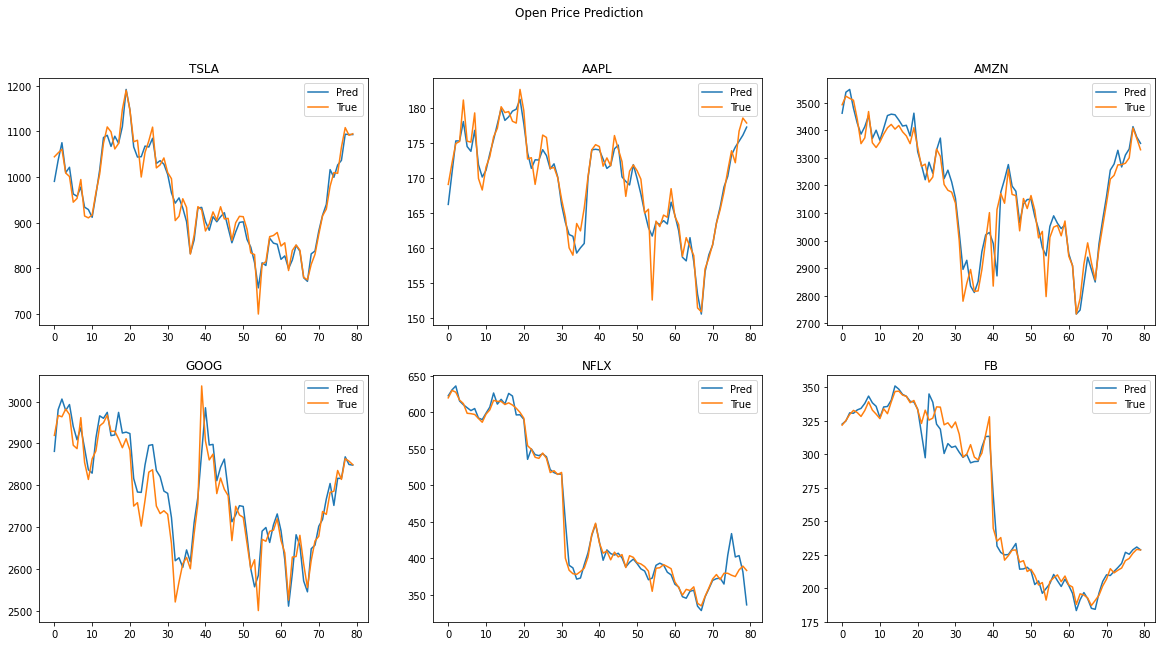

In [42]:
fig, axs = plt.subplots(2, 3,figsize=(20,10))
fig.suptitle('Open Price Prediction')
symbols = ['TSLA', 'AAPL', 'AMZN', 'GOOG','NFLX', 'FB']
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(range(80), revert(y_test_pred, 0)[80*i:80*(i+1)],label='Pred')
    ax.plot(range(80), revert(y_test, 0)[80*i:80*(i+1)],label='True')
    ax.set_title(symbols[i])
    ax.legend()